In [14]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

import ImageTools as it

The Petrosian Radius is the R at which $\frac{1}{\eta(R)}=0.2$, where

$$\frac{1}{\eta(R)}=\frac{\pi r^2}{\sum_r^RI(r)}I(R)$$

In [65]:
def one_over_eta(rs, fs, R):
    return ((np.pi*R**2) / (np.sum(fs[rs<=R]))) * fs[rs==R]

def petrosian_radius(rs, fs):
    r_candidates = np.array([one_over_eta(rs, fs, R) for R in rs])
    return rs[np.square(r_candidates-0.2).argmin()]

The Petrosian Flux is defined as:
$$F_p=\sum_r^{2R_p}I(r)$$
Where $R_p$ is the Petrosian Radius

In [3]:
def petrosian_flux(rs, fs, R_p):
    return np.sum(fs[rs<=2*R_p])

Defining the effective radius using the Petrosian Flux

$$R_e \approx \frac{R_{50}}{1-P_3(R_{90}/R_{50})^{P_4}}$$

Where:

$$R_x = \frac{x}{100} = \frac{\sum_r^{R_x}I(r)}{\sum_r^{2Rp}{I(r)}}, P_3 = 8*10^{-6}, P_4=8.47$$


In [78]:
def R_x(rs, fs, x):
    x /= 100
    sum_ratio = np.cumsum(fs)/np.sum(fs)
    return rs[np.square(sum_ratio-x).argmin()]

def petrosian_Re(R_50, R_90):
    P_3 = 8e-6
    P_4 = 8.47
    return R_50 / (1 - P_3*(R_90/R_50)**P_4)

### Test on a image

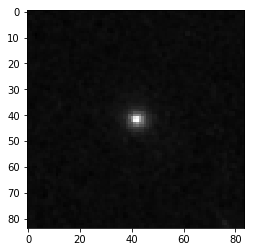

In [110]:
home = os.getenv('HOME')
img_dir = os.path.join(home, 'Documents/astro_data/orig_images')
def get_img(_id, band):
    file_name = 'GDS_{}_{}.fits'.format(_id, band)
    return fits.getdata(os.path.join(img_dir, file_name))

img = get_img('deep2_10042', 'h')
segmap = get_img('deep2_10042', 'segmap')
old_re = it.effective_radius(img, segmap==10042)

plt.imshow(img, cmap='gray')

In [79]:
cx, cy = it.img_center(img, segmap==10042)
xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
rs = np.sqrt(np.square(xs-cx)+np.square(ys-cy))

rs = rs.flatten()
fs = img.flatten()
sorted_rs = np.argsort(rs)

rs = rs[sorted_rs]
fs = fs[sorted_rs]

R_p = petrosian_radius(rs, fs)
F_p = petrosian_flux(rs, fs, R_p)
p_mask = rs <= 2*R_p

rs = rs[p_mask]
fs = fs[p_mask]

R_50 = R_x(rs, fs, 50)
R_90 = R_x(rs, fs, 90)

R_e = petrosian_Re(R_50, R_90)
print(f'Petrosian Radius:{R_p}')
print(f'Petrosian Flux:{fp}')
print(f'R_50:{R_50}')
print(f'R_90:{R_90}')
print(f'Effective Radius:{R_e}')

Petrosian Radius:13.844232169684181
Petrosian Flux:24.300500869750977
R_50:4.492675550751505
R_90:15.294322456773603
Effective Radius:6.043832458640687


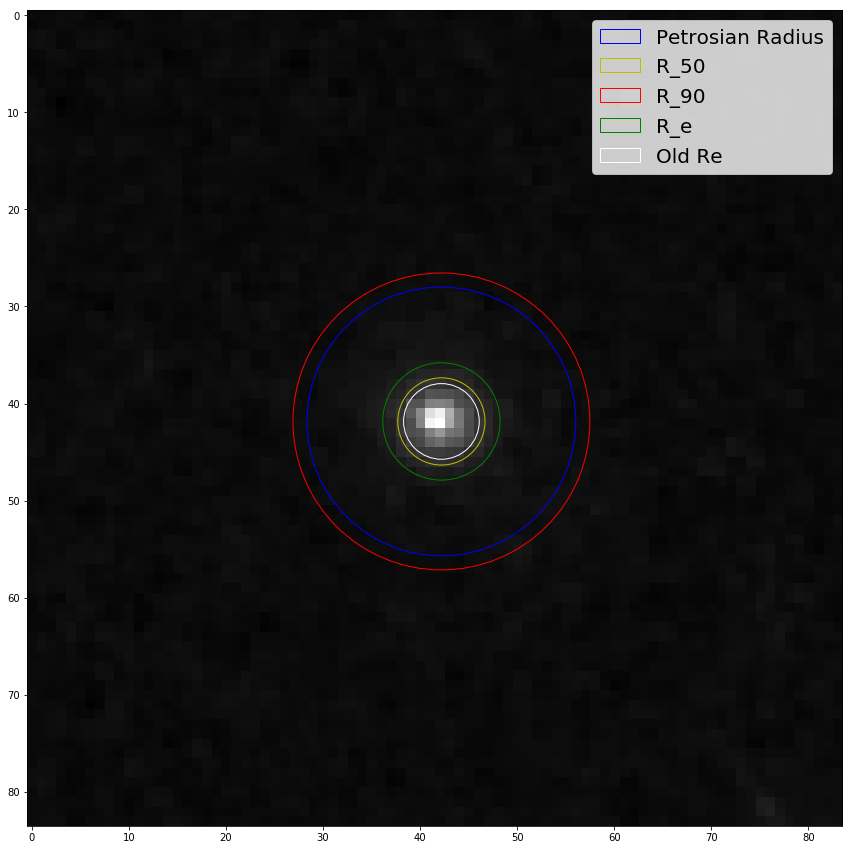

In [115]:
make_cir = lambda r,c: plt.Circle((cx, cy), r, color=c, fill=False)

cir_p_radius = make_cir(R_p, 'b')
cir_R_50 = make_cir(R_50, 'y')
cir_R_90 = make_cir(R_90, 'r')
cir_R_e = make_cir(R_e, 'g')
cir_old_re = make_cir(old_re, 'w')

f, a = plt.subplots(figsize=(15,15))
a.imshow(img, cmap='gray')
a.add_artist(cir_p_radius)
a.add_artist(cir_R_50)
a.add_artist(cir_R_90)
a.add_artist(cir_R_e)
a.add_artist(cir_old_re)
a.legend([cir_p_radius, cir_R_50, cir_R_90, cir_R_e, cir_old_re], 
         ['Petrosian Radius', 'R_50', 'R_90', 'R_e', 'Old Re'],
        fontsize=20)
plt.show()